No valid columns found, using the entire image.


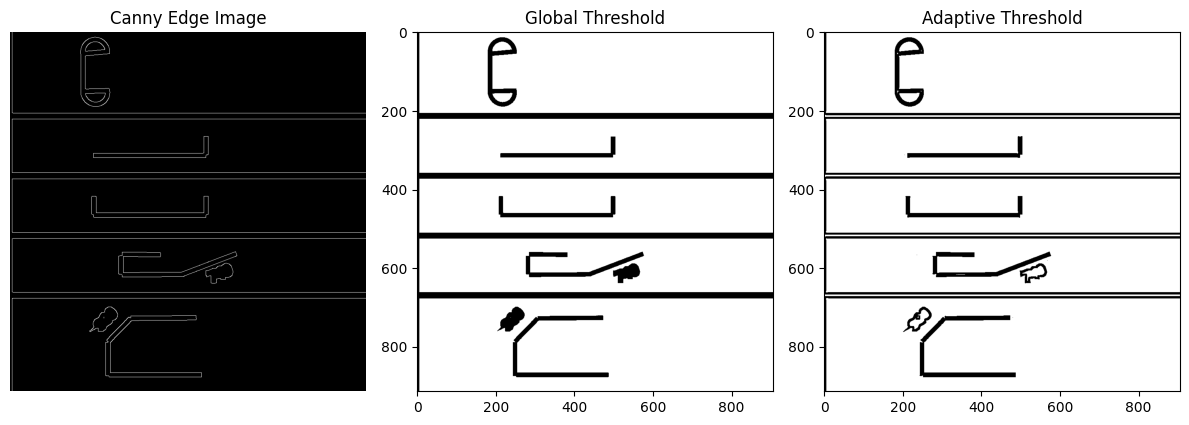

True

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# Load the grayscale image
img_path = "Patches.png"
if not os.path.exists(img_path):
    raise FileNotFoundError(f"The image file '{img_path}' does not exist.")

img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Constants for Canny edge detection
LOWER_CANNY_THRESHOLD = 100
UPPER_CANNY_THRESHOLD = 200

# Constants for edge counting
EDGE_COUNT_THRESHOLD = 25  # Minimum edges to consider a valid column
MIN_COLUMN_WIDTH = 50  # Minimum width for a valid column

# Function to find column boundaries based on edge counts
def find_column_boundaries(edge_count, threshold, min_width):
    column_boundaries = []
    inside_column = False

    for i in range(len(edge_count)):
        if edge_count[i] > threshold and not inside_column:
            column_boundaries.append(i)  # Start of a new column
            inside_column = True
        elif edge_count[i] <= threshold and inside_column:
            column_boundaries.append(i)  # End of the column
            inside_column is False

    valid_columns = []
    i = 0
    while i < len(column_boundaries) - 1:
        start = column_boundaries[i]
        end = column_boundaries[i + 1]
        if end - start >= min_width:
            valid_columns.append((start, end))
        i += 2

    return valid_columns

# Apply Canny edge detection
canny_image = cv2.Canny(img, LOWER_CANNY_THRESHOLD, UPPER_CANNY_THRESHOLD)

# Count edges in each column and find boundaries
edge_count = np.sum(canny_image == 255, axis=0)
valid_columns = find_column_boundaries(edge_count, EDGE_COUNT_THRESHOLD, MIN_COLUMN_WIDTH)

# Determine the cropped image
if valid_columns:
    # Get the start and end column indices from the widest valid column
    start_col, end_col = max(valid_columns, key=lambda x: x[1] - x[0])

    # Adjust start_col and end_col to remove 10 pixels from each side
    start_col = min(start_col + 10, end_col - 10)  # Ensure it doesn't exceed boundaries
    end_col = max(start_col + 10, min(end_col - 10, img.shape[1]))  # Avoid going out of bounds

    cropped_image = img[:, start_col:end_col]
else:
    # If no valid columns, use the entire image
    print("No valid columns found, using the entire image.")
    cropped_image = img

# Apply binary thresholding on the cropped image
global_threshold = 127  # Example threshold value
_, binary_image_global = cv2.threshold(cropped_image, global_threshold, 255, cv2.THRESH_BINARY)

adaptive_threshold_size = 11  # Size of the neighborhood for adaptive thresholding
adaptive_constant = 2  # Constant subtracted from the adaptive threshold
binary_image_adaptive = cv2.adaptiveThreshold(
    cropped_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, adaptive_threshold_size, adaptive_constant
)

# Visualize the results
plt.figure(figsize=(12, 6))

# Display Canny edge image
plt.subplot(1, 3, 1)
plt.imshow(canny_image, cmap='gray')
plt.title("Canny Edge Image")
plt.axis("off")

# Display global threshold image
plt.subplot(1, 3, 2)
plt.imshow(binary_image_global, cmap='gray')
plt.title("Global Threshold")

# Display adaptive threshold image
plt.subplot(1, 3, 3)
plt.imshow(binary_image_adaptive, cmap='gray')
plt.title("Adaptive Threshold")

plt.tight_layout()
plt.show()

# Optional: Save the binary images if needed
cv2.imwrite("binary_image_global.jpg", binary_image_global)
cv2.imwrite("binary_image_adaptive.jpg", binary_image_adaptive)


Saved cropped rows to the 'ShapesFinal1' folder.


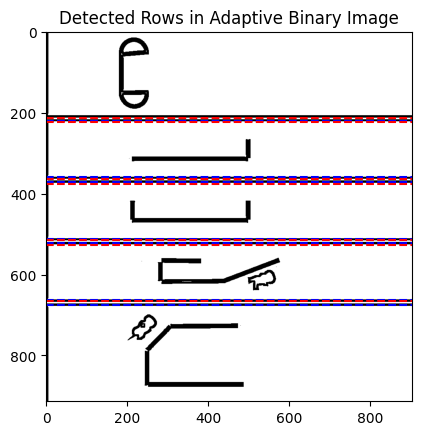

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# Function to detect rows in a binary image based on edge count
def detect_rows(binary_img, row_threshold=35, min_row_width=5, max_row_width=150):
    row_sums = np.sum(binary_img, axis=1)
    in_row = False
    start = None
    rows = []

    for i, sum_value in enumerate(row_sums):
        if sum_value > row_threshold and not in_row:
            start = i
            in_row = True
        elif sum_value <= row_threshold and in_row:
            if start is not None:
                row_width = i - start
                if min_row_width <= row_width <= max_row_width:
                    rows.append((start, i))
            in_row = False

    # Handle edge case for a row ending at the last pixel
    if in_row and start is not None:
        row_width = len(row_sums) - start
        if min_row_width <= row_width <= max_row_width:
            rows.append((start, len(row_sums)))

    return rows

# Function to save cropped rows with a specified white border width
def save_cropped_rows(binary_img, rows, output_folder, border_width=10):
    # Ensure the output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for idx, (start, end) in enumerate(rows):
        # Crop the row from the binary image
        row_img = binary_img[start:end, :]

        # Check if the cropped image is pure white (no shapes)
        if np.all(row_img == 255):
            print(f"Row {idx + 1} is entirely white, skipping.")
            continue

        # Add a white border around the cropped row
        height, width = row_img.shape[:2]
        new_height = height + 2 * border_width

        # Create a white background with the desired dimensions
        border_img = np.ones((new_height, width), dtype=np.uint8) * 255  # White background

        # Place the cropped row image with a white border
        border_img[border_width:height + border_width, :] = row_img

        # Create a filename for the row image
        row_path = os.path.join(output_folder, f"row_{idx + 1}.jpg")

        # Save the cropped row image with the border
        cv2.imwrite(row_path, border_img)

    print(f"Saved cropped rows to the '{output_folder}' folder.")

# Example code to demonstrate the use of these functions
# Load the adaptive binary image
adaptive_binary_img = cv2.imread("binary_image_adaptive.jpg", cv2.IMREAD_GRAYSCALE)

# Detect rows in the adaptive binary image
detected_rows = detect_rows(adaptive_binary_img, row_threshold=35, min_row_width=5, max_row_width=150)

# Save the detected rows with a specified white border to the "ShapesFinal" folder
save_cropped_rows(adaptive_binary_img, detected_rows, "ShapesFinal1", border_width=10)

# Optional: Visualize the detected rows for verification
plt.imshow(adaptive_binary_img, cmap='gray')
for (start, end) in detected_rows:
    plt.axhline(y=start, color='red', linestyle='--')  # Draw lines at row boundaries
    plt.axhline(y=end, color='blue', linestyle='--')

plt.title("Detected Rows in Adaptive Binary Image")
plt.show()

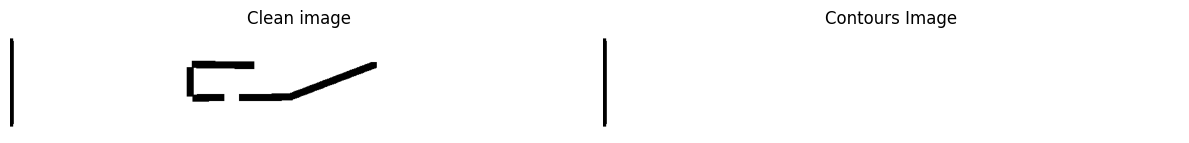

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def remove_small_objects(image, min_area):
    """
    Removes small objects from a binary image.
    This also ensures the contours are filled properly.

    Args:
        image: The binary image as a NumPy array.
        min_area: The minimum area (in pixels) of a contour to keep.

    Returns:
        A new binary image with small objects removed.
    """
    # Find contours in the image
    contours, _ = cv2.findContours(image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a mask to store the results
    mask = np.zeros(image.shape, dtype=np.uint8)

    # Fill contours that meet or exceed the minimum area
    for cnt in contours:
        if cv2.contourArea(cnt) >= min_area:
            cv2.drawContours(mask, [cnt], -1, 255, thickness=cv2.FILLED)  # Fill the contour

    return mask

# Load the image
image = cv2.imread("row_6.jpg")

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply binary thresholding
binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)[1]

# Use morphological closing to fill in small holes
kernel = np.ones((5, 5), dtype=np.uint8)
closed_binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)  # Close small gaps

# Define minimum area to retain (larger to remove smaller patches)
min_area = 200  # Adjust as needed

# Remove small objects using a filled contour approach
cleaned_image = remove_small_objects(closed_binary, min_area)

# Display the images
plt.figure(figsize=(12, 6))

# Original binary image
plt.subplot(121)
plt.imshow(closed_binary, cmap="gray")
plt.title("Clean image")
plt.axis("off")

# Cleaned image with small objects removed
plt.subplot(122)
plt.imshow(cleaned_image, cmap="gray")
plt.title("Contours Image")
plt.axis("off")

plt.tight_layout()
plt.show()


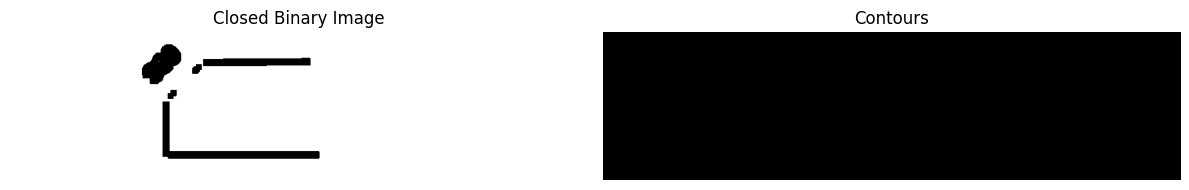

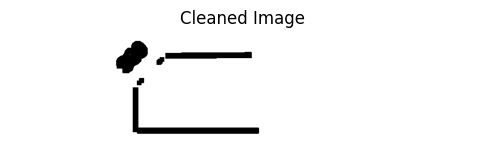

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image and convert it to grayscale
image_path = "p2.png"
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Image '{image_path}' not found.")

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply binary thresholding to create a binary image
binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)[1]

# Use morphological closing to fill small holes
kernel = np.ones((5, 5), dtype=np.uint8)  # Create a kernel for morphology
closed_binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)

# Find contours to examine their properties
contours, _ = cv2.findContours(closed_binary.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Display the original binary image and closed binary image
plt.figure(figsize=(12, 6))

# Original binary image after closing
plt.subplot(121)
plt.imshow(closed_binary, cmap="gray")
plt.title("Closed Binary Image")
plt.axis("off")

# Display contours on a blank image for visualization
contour_visualization = np.zeros_like(closed_binary)
cv2.drawContours(contour_visualization, contours, -1, (255, 255, 255), thickness=cv2.FILLED)

plt.subplot(122)
plt.imshow(contour_visualization, cmap="gray")
plt.title("Contours")
plt.axis("off")

plt.tight_layout()
plt.show()

# Now we can see if contours are detected properly

# Define the function to remove small objects
def remove_small_objects(image, min_area):
    # Create a mask to store the results
    mask = np.zeros_like(image)

    # Fill contours that meet or exceed the minimum area
    for cnt in contours:
        contour_area = cv2.contourArea(cnt)  # Get the area of the contour
        if contour_area >= min_area:
            cv2.drawContours(mask, [cnt], -1, 255, thickness=cv2.FILLED)  # Fill the contour
        else:
            print(f"Removing contour with area {contour_area}.")  # Debugging output

    return cv2.bitwise_and(image, mask)

# Set the minimum area for small object removal
min_area = 200  # Start with a smaller value

# Clean the binary image by removing small objects
cleaned_image = remove_small_objects(closed_binary, min_area)

# Display the cleaned image
plt.figure(figsize=(6, 6))
plt.imshow(cleaned_image, cmap="gray")
plt.title("Cleaned Image")
plt.axis("off")
plt.show()


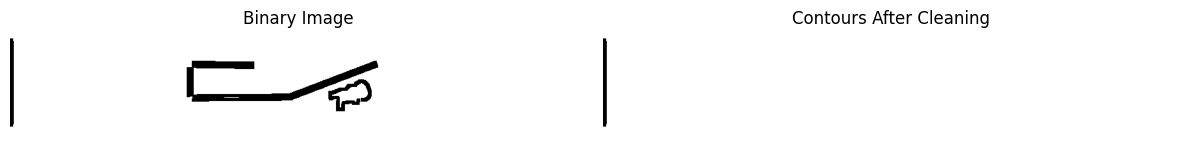

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def remove_small_objects(image, min_area):
    """
    Removes small objects from a binary image.
    """
    contours, _ = cv2.findContours(image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a mask for the output image
    mask = np.zeros(image.shape, dtype=np.uint8)

    # Draw only contours that meet or exceed the minimum area
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area >= min_area:
            cv2.drawContours(mask, [cnt], -1, 255, thickness=cv2.FILLED)  # Fill the contour

    return mask

# Load the image
image_path = "row_6.jpg"  # Replace with your image path
image = cv2.imread(image_path)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply binary thresholding
threshold_value = 127  # Adjust as needed
binary = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY)[1]

# Morphological closing to fill gaps
kernel_size = (5, 5)  # Adjust as needed
kernel = np.ones(kernel_size, dtype=np.uint8)
closed_binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=1)  # Lower iterations to avoid over-filling

# Define minimum area to retain (lower for testing)
min_area = 50  # Reduced from 200 to 50 to check smaller contours

# Remove small objects
cleaned_image = remove_small_objects(closed_binary, min_area)

# Display the original and cleaned images
plt.figure(figsize=(12, 6))

# Original binary image
plt.subplot(121)
plt.imshow(closed_binary, cmap="gray")
plt.title("Binary Image")
plt.axis("off")

# Cleaned image with small objects removed
plt.subplot(122)
plt.imshow(cleaned_image, cmap="gray")
plt.title("Contours After Cleaning")
plt.axis("off")

plt.tight_layout()
plt.show()


In [2]:
import cv2
import numpy as np

# Load the image
image = cv2.imread('3.png')

# Convert to grayscale for easier processing
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise
blurred_image = cv2.GaussianBlur(gray_image, (7, 7), 0)

# Adaptive thresholding to remove uneven illumination and focus on the wire shapes
thresh_image = cv2.adaptiveThreshold(
    blurred_image,
    255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY,
    11,  # Block size
    2,  # Constant subtracted from mean
)

# Invert the threshold to make wire shapes white on a black background
thresh_image = cv2.bitwise_not(thresh_image)

# Perform morphological operations to clean up small disturbances and connect wire segments
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
cleaned_image = cv2.morphologyEx(thresh_image, cv2.MORPH_OPEN, kernel, iterations=2)

# Apply morphological closing to close gaps in the wire shapes
cleaned_image = cv2.morphologyEx(cleaned_image, cv2.MORPH_CLOSE, kernel, iterations=2)

# Find contours in the cleaned image
contours, _ = cv2.findContours(cleaned_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw the wire contours on a new image
wire_image = np.zeros_like(gray_image)  # Create a blank image
cv2.drawContours(wire_image, contours, -1, (255, 255, 255), thickness=cv2.FILLED)

# Save the cleaned wire image
cv2.imwrite('cleaned_wire_image.jpg', wire_image)

# Display the result (if in a Jupyter notebook or similar environment)
# Uncomment the lines below if you're running in an interactive environment
# import matplotlib.pyplot as plt
# plt.imshow(wire_image, cmap='gray')
# plt.show()


True